39000


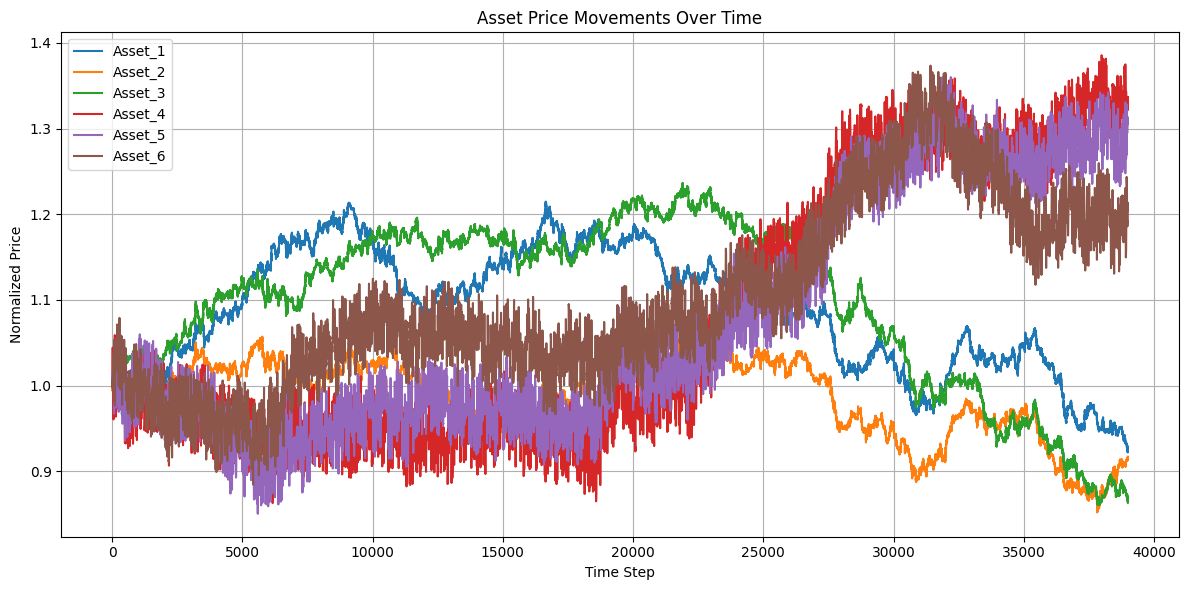

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Case2.csv')
print(len(data))
plt.figure(figsize=(12, 6))
for col in data.columns:
    plt.plot(range(len(data)), data[col], label=col)

plt.title("Asset Price Movements Over Time")
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


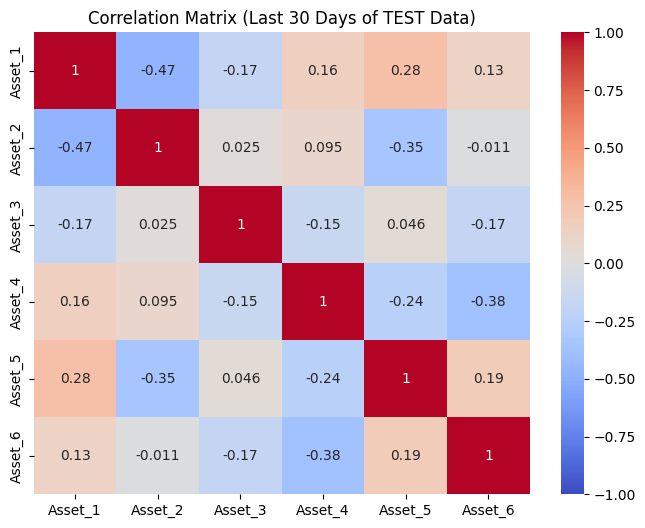

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate daily returns from the full TEST set
returns = data.pct_change().dropna()

# Use the last 30 days of returns
recent_returns = returns.iloc[-30:]

# Compute the correlation matrix
corr_matrix = recent_returns.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix (Last 30 Days of TEST Data)")
plt.show()


0.04153958281242755
Capital shape: 7800 | Test shape: 7800


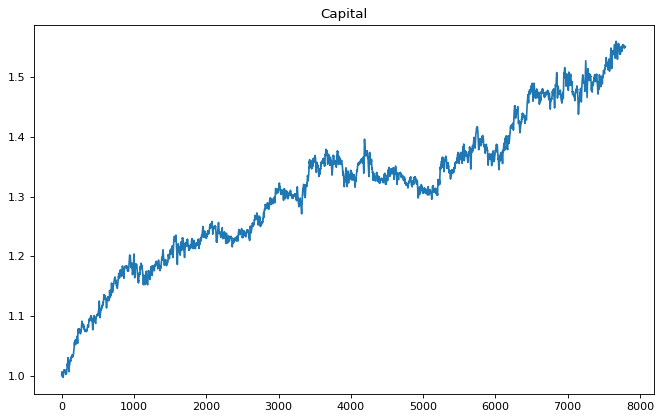

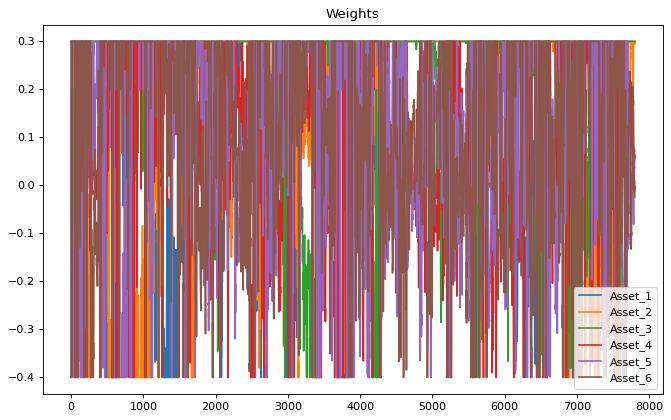

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from cvxopt import matrix, solvers, blas
from scipy.optimize import minimize


data = pd.read_csv('Case2.csv')

'''
We recommend that you change your train and test split
'''

TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)


class Allocator():
    def __init__(self, train_data):
        '''
        Store raw prices and calculate running returns separately
        '''
        self.running_price_paths = train_data.copy()  # raw prices
        self.daily_returns = train_data.pct_change().dropna().copy()  # daily percent change

        self.train_data = train_data.copy()

    def allocate_portfolio(self, asset_prices):
        new_row = pd.DataFrame([asset_prices], columns=self.train_data.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

        # Update returns
        if len(self.running_price_paths) >= 2:
            last_return = self.running_price_paths.iloc[-1] / self.running_price_paths.iloc[-2] - 1
            self.daily_returns = pd.concat(
                [self.daily_returns, pd.DataFrame([last_return], columns=self.train_data.columns)],
                ignore_index=True
            )

        if len(self.daily_returns) < 200:
            return np.full(6, 1/6)

        recent_returns = self.daily_returns.iloc[-200:]
        mu = recent_returns.mean().values
        cov = recent_returns.cov().values
        n = len(mu)

        def negative_sharpe(w):
            ret = np.dot(w, mu)
            vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
            return ret / vol if vol > 0 else 1e6

        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(-0.4, 0.3)] * n
        w0 = np.full(n, 1/n)

        result = minimize(negative_sharpe, w0, bounds=bounds, constraints=constraints)

        if result.success:
            return result.x
        else:
            return w0

def grading(train_data, test_data):
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")

    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]

    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0

    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print(sharpe)
print("Capital shape:", len(capital), "| Test shape:", len(TEST))

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()